In [1]:
import os, sys
from pathlib import Path
import uuid
sys.path.append('..')

from chat.customer_support.graphs import get_zero_shot_graph
from chat.customer_support.utils import get_travel_db, restore_db, _print_event

os.environ['LANGCHAIN_TRACING_V2'] = "true"
os.environ['LANGCHAIN_PROJECT'] = "Customer Support Bot Tutorial"

get_travel_db()

/Users/achinta/miniforge3/envs/langgraph/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 47127.01it/s]


'/Users/achinta/github/machine-learning/notebooks/travel2.sqlite'

In [2]:
from openinference.instrumentation.openai import OpenAIInstrumentor
# from openinference.instrumentation.dspy import DSPyInstrumentor
from opentelemetry import trace as trace_api
from opentelemetry.exporter.otlp.proto.http.trace_exporter import OTLPSpanExporter
from opentelemetry.sdk import trace as trace_sdk
from opentelemetry.sdk.trace.export import SimpleSpanProcessor
import os

phoenix_url = os.getenv('PHOENIX_URL', 'http://127.0.0.1:6006')
endpoint = f"{phoenix_url}/v1/traces"
tracer_provider = trace_sdk.TracerProvider()
span_otlp_exporter = OTLPSpanExporter(endpoint=endpoint)
tracer_provider.add_span_processor(SimpleSpanProcessor(span_exporter=span_otlp_exporter))
trace_api.set_tracer_provider(tracer_provider=tracer_provider)
OpenAIInstrumentor().instrument()
# DSPyInstrumentor().instrument()

## Zero Shot Graph

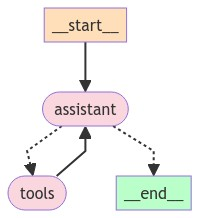

In [3]:
from IPython.display import Image, display

zero_shot_graph = get_zero_shot_graph()

try:
    display(Image(zero_shot_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)
    pass

In [4]:
#  Let's create an example conversation a user might have with the assistant
tutorial_questions = [
    "Hi there, what time is my flight?",
    "Am i allowed to update my flight to something sooner? I want to leave later today.",
    "Update my flight to sometime next week then",
    "The next available option is great",
    "what about lodging and transportation?",
    "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    "OK could you place a reservation for your recommended hotel? It sounds nice.",
    "yes go ahead and book anything that's moderate expense and has availability.",
    "Now for a car, what are my options?",
    "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    "Cool so now what recommendations do you have on excursions?",
    "Are they available while I'm there?",
    # "interesting - i like the museums, what options are there? ",
    # "OK great pick one and book it for my second day there.",
]

In [5]:
# Update with the backup file so we can restart from the original place in each section
from langchain_core.messages.human import HumanMessage
restore_db()
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

# text = tutorial_questions[0]
# inputs = {"messages": [HumanMessage(content=f"{text}")]}
# output = zero_shot_graph.invoke(inputs, config)
# output


# _printed = set()
# for question in tutorial_questions:
#     events = zero_shot_graph.stream(
#         {"messages": ("user", question)}, config, stream_mode="values"
#     )
#     for event in events:
#         _print_event(event, _printed)

    

## 2. User Confirmation


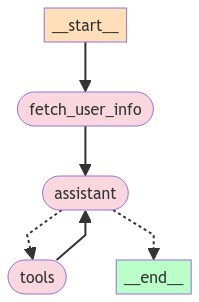

In [6]:
from chat.customer_support.graphs import get_graph_with_confirmation_v2

from IPython.display import Image, display

graph_with_confirmation_v2 = get_graph_with_confirmation_v2()

try:
    display(Image(graph_with_confirmation_v2.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [12]:
from langchain_core.messages import ToolMessage
restore_db()
thread_id = str(uuid.uuid4())
config = { "configurable": { "passenger_id": "3442 587242", "thread_id": thread_id, } }

_printed = set()
for question in tutorial_questions:
    events = graph_with_confirmation_v2.stream(
        {"messages": ("user", question)}, config, stream_mode="values", debug=True
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = graph_with_confirmation_v2.get_state(config)
    while snapshot.next:
        user_input = input( "Do you approve of the above actions? Type 'y' to continue;" " otherwise, explain your requested changed.\n\n")
        if user_input.strip() == "y":
            result = graph_with_confirmation_v2.invoke( None, config,)
        else:
            # Satisfy the tool invocation by providing instructions on the requested changes / change of mind
            result = graph_with_confirmation_v2.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = graph_with_confirmation_v2.get_state(config)


[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting step 0 with 1 task:
- __start__ -> {'messages': ('user', 'Hi there, what time is my flight?')}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> ('user', 'Hi there, what time is my flight?')
================================ Human Message =================================

Hi there, what time is my flight?
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='Hi there, what time is my flight?', id='87c8b56b-529e-4f2b-a2f1-f7091eba6cbe')]}
[1:tasks] Starting step 1 with 1 task:
- fetch_user_info -> {'messages': [HumanMessage(content='Hi there, what time is my flight?', id='87c8b56b-529e-4f2b-a2f1-f7091eba6cbe')],
 'user_info': None}
[1:writes] Finished step 1 with writes to 1 channel:
- user_info -> [{'arrival_airport': 'BSL',
  'book_ref': 'C46E9F',
  'departure_airport': 'CDG',
  'fare_conditions': 'Economy',
  'flight_id': 19250,
  'flight_no': 'LX0112',
  'schedu

KeyboardInterrupt: 

In [ ]:
import json
from pathlib import Path
prompt = json.load(open(Path.home()/'mytemp/prompt.json'))
# format the prompt json and save it to same file
# formatted = json.dumps(prompt, indent=4)
# with open(Path.home()/'mytemp/prompt.json', 'w') as f:
#     f.write(formatted)

from operator import itemgetter

In [ ]:
prompt.keys()